In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTForMaskedImageModeling
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
# from vit_model import ViTForMultitask3, ViTForImageClassification2
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)


# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

In [2]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"

image = Image.open(requests.get(url, stream=True).raw)
# def load_data(): 
#     dataset = load_dataset("mrm8488/ImageNet1K-val")
#     dataset = dataset['train']
#     splits = dataset.train_test_split(test_size=0.1, seed=42)
#     test_ds = splits['test']
#     splits = splits['train'].train_test_split(test_size=0.1, seed=42)
#     train_ds = splits['train']
#     val_ds = splits['test']
#     return train_ds, val_ds, test_ds

# train_ds, val_ds, test_ds = load_data()

# image = train_ds[1]['image']

pretrained_name = 'google/vit-base-patch16-224'

config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)

# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: tiger shark, Galeocerdo cuvieri


# Load RISE model

In [20]:
# from maskgen.models.random_mask import RandomMaskSaliency
from maskgen.utils.img_utils import generate_mask
from maskgen.utils import idx_to_selector

def batch_combine(x, func, n_batch_dims=1):
    """ 
    Temperarily combine multiple dimensions into one batch dimension in order to feed to functions
    that doesn't support multiple batch dimensions.
    Args:
        x: input
        func: function to be passed to
        batch_dims: number of dimensions to be combined, starting from the 0th dimension
    return:
        output having the corresponding shape of x
    """
    shape = x.shape
    batch_shape, rest_shape = shape[:n_batch_dims + 1], shape[n_batch_dims + 1:]
    combined_batch_shape = [np.prod(batch_shape),]
    res = func(x.reshape(combined_batch_shape + rest_shape))
    return res.reshape(batch_shape + rest_shape)


class BatchRandomMaskSaliency():
    """
    Batched version of RandomMaskSaliency
    """

    def __init__(self, model, num_classes):
        """
        Initialize the BatchRandomMaskSaliency class.

        Args:
            model: The model that outputs logits.
            num_classes: The number of classes.

        Returns:
            None
        """
        super().__init__()

        self.model = model
        self.num_classes = num_classes
    

    def attribute_img(self, 
                      x, 
                      image_size=224, 
                      patch_size=16, 
                      baseline=None, 
                      n_samples=1000,
                      mask_prob=0.7,
                      seed=None):
        """
        Generate attribution heatmap for an input image.

        Args:
            x: An image tensor of shape [N, C, H, W], where H = W = image_size.
            image_size: The size of the input image (H = W = image_size).
            patch_size: The size of each patch. Can be used to calculate the number of tokens in each patch 
                        (image_size // patch_size) ** 2.
            baseline: The baseline tensor. If None, the baseline is set to the zero tensor.
            n_samples: The number of random masks to be generated.
            mask_prob: The probability of a token being masked, i.e., replaced by the baseline.
            seed: The seed value for random number generation.

        Returns:
            Attribution heatmap.
        """

        device = x.device
        size = image_size // patch_size
        N, C, H, W = x.shape
        with torch.no_grad():
            # Get the original prediction idx and the selector
            predicted_class_idx = self.model(x).argmax(-1) # [N, 1]
            selector = idx_to_selector(predicted_class_idx, self.num_classes) # [N, n_classes]
            selector = selector.unsqueeze(1) # [N, 1, n_classes]

            # Generate a random mask and reshape to the proper size.
            mask = generate_mask(mask_size=size*size, mask_probability=mask_prob, batch_size=n_samples*N, seed=seed)
            mask = mask.to(device)
            mask = mask.reshape(-1, 1, size, size) # [n_samples*N, 1, size, size]

            # Interpolate mask to the size of the original image.
            masked_pixels = F.interpolate(mask, x.shape[-2:], mode='nearest') # [n_samples*N, 1, H, W]

            # A number of `n_samples` randomly masked inputs
            x_expand = x.unsqueeze(1).expand(-1, n_samples, -1, -1, -1).reshape(N*n_samples, C, H, W) # [N * n_samples, C, H, W]
            x_masked = x_expand * (1 - masked_pixels) # [N*n_samples, C, H, W]

            # Obtain the output probabilities of the masked inputs for the true predicted class.
            logits = self.model(x_masked) # [N*n_samples, n_classes]
            logits = logits.reshape(N, n_samples, self.num_classes)  # [N, n_samples, n_classes]
            probs = torch.softmax(logits, dim=-1) # [N, n_samples, n_classes]


            # Only consider the masks with correct predictions. Weighted usign probs
            # correct_idx = (logits.argmax(-1) == predicted_class_idx.unsqueeze(-1)).float() # [N, n_samples, 1]

            probs = ((probs * selector)).sum(-1, keepdim=True) # [N, n_samples, 1]
            probs = probs.unsqueeze(-1).unsqueeze(-1) # [N, n_samples, 1, 1, 1]

            # Weighted mask
            mask = mask.reshape(N, n_samples, 1, size, size) # [N, n_samples, 1, size, size]
            # weighted_mask = (probs * (1 - mask)).sum(1) / probs.sum(1) # [N, 1, size, size]
            weighted_mask = (probs * (1-mask)).sum(1) / (1-mask).sum(1)
        
        return weighted_mask.squeeze(1)
    
    def attribute_text(self, x, baseline=None, n_samples=1000,):
        # TODO
        raise NotImplementedError("This function hasn't been developed.")

model = lambda x: pred_model(pixel_values=x).logits
# random_mask = RandomMaskSaliency(model, num_classes=config.num_labels)
random_mask = BatchRandomMaskSaliency(model, num_classes=config.num_labels)

# random_mask.eval()

# Demo examples

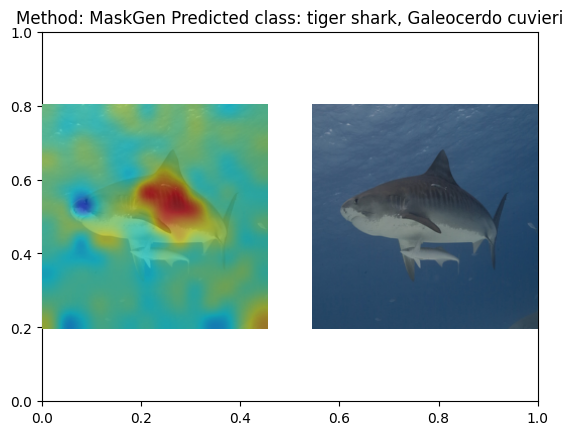

In [21]:
from maskgen.utils.img_utils import plot_overlap_np

n_samples = 1000

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"

image1 = Image.open(requests.get(url, stream=True).raw)

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"


image2 = Image.open(requests.get(url, stream=True).raw)

image = [image1, image2]

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1)

idx = 1
plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx[idx].item()]}")
# heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=patch_size)
# for _ in range(10):
heatmap = random_mask.attribute_img(inputs['pixel_values'],
                                    image_size=config.image_size, 
                                    patch_size=config.patch_size, 
                                    n_samples=n_samples, 
                                    mask_prob=0.5)

# heatmap = heatmaps[idx].detach().cpu().numpy()
heatmap = heatmap[1].detach().cpu().numpy()
img = img[idx].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [22]:
heatmap[1]

array([0.90478903, 0.8966629 , 0.90190554, 0.89882094, 0.90233433,
       0.9128413 , 0.9098503 , 0.9121175 , 0.90575653, 0.9161363 ,
       0.9093565 , 0.911892  , 0.9095918 , 0.90815085], dtype=float32)

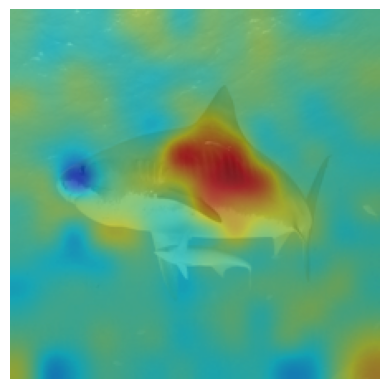

In [23]:
# display only the image without axis and titles 
from maskgen.utils.img_utils import plot_overlap_np, plot_overlap
plot_overlap(img_int, heatmap_img)

# batch evaluation

In [24]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 4
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
# test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [26]:
from maskgen.evaluation import EvalGame
from tqdm import tqdm

n_samples = 10

# random_mask
root_path = 'results/rise-vit'

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    attr = random_mask.attribute_img(pixel_values,
                                image_size=config.image_size, 
                                patch_size=config.patch_size, 
                                n_samples=n_samples, 
                                mask_prob=0.5)

    heatmap = attr # [1, 14, 14]
    # heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    heatmap_list.append(heatmap)
    # if (idx + 1) * batch_size % 100 == 0:
    #     heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
    #     save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
    #     heatmap_list = []


if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# heatmap = heatmap_list

1250it [02:17,  9.07it/s]


In [28]:
(outputs.logits.argmax(-1) == predicted_class_idx).sum().item()

96

In [29]:
weighted_mask = (probs.reshape(-1, 1, 1, 1) * (1 - mask)).sum(0).squeeze(0).cpu().detach().numpy()

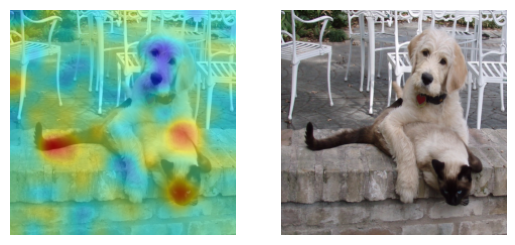

In [30]:
from utils.img_utils import plot_overlap_np, unnormalize
img = x[0].cpu().detach().numpy().transpose(1,2,0)
heatmap = weighted_mask
_, _ = plot_overlap_np(img, heatmap, mean, std)

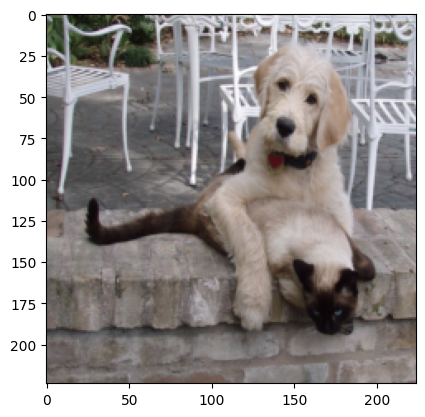

In [31]:
plt.imshow(unnormalize(img, mean, std))

In [17]:
heatmap

array([[ 58.186424,  61.055916,  61.382248,  67.58034 ,  64.80177 ,
         79.05661 ,  53.031754,  63.09465 ,  50.746983,  56.581078,
         66.20289 ,  63.827133,  57.694244,  64.04315 ],
       [ 57.50766 ,  63.9122  ,  57.083656,  61.646793,  67.5721  ,
         68.71352 ,  72.5482  ,  61.740685,  68.45509 ,  62.468475,
         62.40585 ,  64.08422 ,  69.73269 ,  64.203354],
       [ 62.458637,  62.464287,  63.2369  ,  69.06065 ,  65.706764,
         55.057156,  51.73078 ,  71.179596,  62.63135 ,  59.658974,
         62.398094,  62.887512,  55.056046,  59.565445],
       [ 61.27293 ,  60.798843,  55.35553 ,  57.318287,  63.552315,
         63.153473,  63.377987,  59.837692,  68.60625 ,  66.92128 ,
         64.078156,  70.73664 ,  57.341595,  62.310024],
       [ 58.968933,  65.61713 ,  67.01606 ,  75.102295,  65.079445,
         63.493305,  67.1535  ,  71.596275,  87.22081 ,  65.87288 ,
         62.284485,  66.797104,  71.87813 ,  66.70825 ],
       [ 67.72168 ,  64.77152 ,  58